In [62]:
from math import floor, ceil

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import queue
import glob
import os
import json
from PIL import Image, ImageDraw
from shapely import wkt, geometry
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn.model_selection import train_test_split

#### PATH TO DATA

In [7]:
SIZE_CUTS = 128              # size of the sub images extracted (in pixels)
SIZE_BUILDING_SEARCH = 32    # size of the granularity for building detection (should be smaller than SIZE_CUTS)

points_grid = [[geometry.Point(SIZE_BUILDING_SEARCH*i+SIZE_BUILDING_SEARCH//2, \
                SIZE_BUILDING_SEARCH*j+SIZE_BUILDING_SEARCH//2) \
                for j in range((2**10)//SIZE_BUILDING_SEARCH)] for i in range((2**10)//SIZE_BUILDING_SEARCH)]
all_points_grid = [[geometry.Point(i, j) for j in range(2**10)] for i in range(2**10)]


## CHANGE PATH ACCORDINGLY (all images and )
PATH_TO_DATASET = "D:\\Datasets\\2019 - Polytechnique - Hackathon Septembre\\Sujets\\XView2\\train\\"


def get_incident_list():
    '''
    output: list of events id
    '''
    return [f[:-18] for f in os.listdir(PATH_TO_DATASET) if 'post_disaster.png' in f]
incidents_id = get_incident_list()

## DATA UTILITIES

In [8]:
def get_image(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: numpy array 1024*1024*3
    '''
    post = "_post_disaster.png" if post else "_pre_disaster.png"
    fname = PATH_TO_DATASET + incident_id + post
    return np.array(Image.open(fname))

def get_label(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: dictionary:
                - "features" (properties of the image):
                    list of info for each building as dictionary:
                        - "uid" (string) id of the building
                        - "wkt" (list): list of the integer coordinates of the box for the building
                        - "damage" (int): 0 to 3 or -1, refer to the classification (only for post data)
                - "metadata": dictionary with
                    - "gsd" (ground sample distance)
                    - "off_nadir_angle"
                    - "sun_azimuth"
                    - "sun_elevation"
                    - "target_azimuth"
                    - "disaster"
                    - "disaster_type"
                    - "width"
                    - "height"
    '''
    postfixe = "_post_disaster.json" if post else "_pre_disaster.json"
    with open(PATH_TO_DATASET + incident_id + postfixe) as json_file:
        data = json.load(json_file)
        
    # Filter available fields for the features
    data["features"] = data["features"]["xy"]
    for b in range(len(data["features"])):
        building = data["features"][b]
        building_filtered = {"uid": building["properties"]["uid"]}
        polygon = wkt.loads(building['wkt'])
        polygon = np.array(list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])))
        building_filtered["wkt"] = polygon
        if post:
            damage = {'destroyed':4, 'major-damage':3, 'minor-damage':2, 'no-damage':1, \
                      'un-classified':0}[building['properties']["subtype"]]
            building_filtered["damage"] = damage
        data["features"][b] = building_filtered
    
    # Filter available fields for the metadata
    metadataFields = ["gsd", "off_nadir_angle", "sun_aizmuth", "sun_elevation", "target_azimuth", \
                     "disaster", "disaster_type", "width", "height"]
    data["metadata"] = {k:v for k,v in data["metadata"].items() if k in metadataFields}
    
    return data



def extract_images2(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: list of pairs (sub images, damage) (length 2**20 / sizeCut^2, each sub image has size sizeCut*sizeCut)
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1))    
    
    # Detection of buildings
    number_division = 2**10//SIZE_BUILDING_SEARCH
    buildings_array = np.zeros((number_division, number_division))
    for coordinates,l in buildings_labels :
        for x,y in coordinates :
            i,j = int(x // SIZE_BUILDING_SEARCH), int(y // SIZE_BUILDING_SEARCH)
            i,j = max(i,0), max(j,0)
            i,j = min(i,number_division-1),min(j,number_division-1)
            buildings_array[i,j] = 1
    # Extract subimages
    subImages = []
    fact = SIZE_CUTS//SIZE_BUILDING_SEARCH
    for i in range(2**10 // SIZE_CUTS):
        for j in range(2**10 // SIZE_CUTS):
            subImages.append((img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS], 
                              buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact]))
    return subImages



## LABELS AND SCORING

In [15]:
def label_image(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: np.array with size 1024*1024*5, the third dimension giving the classes
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1)) 
    labeled_img = np.zeros((1024,1024,5))
    labeled_img[:,:,0] += 1
    for b in buildings_labels:
        zone = [(floor(b[0][:,0].min()), floor(b[0][:,1].min())), (ceil(b[0][:,0].max()), ceil(b[0][:,1].max()))]
        polygon = geometry.Polygon(b[0])
        for i in range(zone[1][0]-zone[0][0]+1):
            for j in range(zone[1][1]-zone[0][1]+1):
                if polygon.contains(all_points_grid[zone[0][0]+i][zone[0][1]+j]):
                    labeled_img[zone[0][0]+i, zone[0][1]+j, 0] = 0
                    labeled_img[zone[0][0]+i, zone[0][1]+j, b[1]] = 1
    
    return labeled_img


def score_full(ypred, ytrue):
    pass

def score_reduct_

### Simple example for building detection with tf

In [75]:
class Dataset_generator(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024//SIZE_CUTS)**2) * len(ids) ) // batch_size
    def get_next_images(self):
        for data in extract_images2(self.ids[self.im_index], False):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    def __len__(self) :
        return self.steps_per_epoch
    def __getitem__(self, idx):
        x = []
        y = []
        for i in range(self.batch_size) :
            if self.sub_image_queue.empty():
                self.get_next_images()
            image,label = self.sub_image_queue.get()
            x.append(image)
            y.append(label)
        return np.array(x), np.array(y) ,  np.max(np.max(np.array(y),axis=1), axis=1)*50+0.5

In [41]:
#pretrained_model =  keras.applications.MobileNet(include_top=False, input_shape=(SIZE_CUTS,SIZE_CUTS,3))
pretrained_model = keras.applications.ResNet50(include_top=False, input_shape=(SIZE_CUTS,SIZE_CUTS,3))
pretrained_model.trainable = False

C:\Users\charl\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 36s 0us/step


In [42]:
model = keras.Sequential()
model.add(pretrained_model)
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.GaussianNoise(1))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.add(keras.layers.Reshape((SIZE_CUTS // SIZE_BUILDING_SEARCH, SIZE_CUTS // SIZE_BUILDING_SEARCH)))
#model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [44]:
incidents_id = get_incident_list()
batch_size = 16

In [58]:
train, test = train_test_split(np.random.choice(incidents_id, 111), test_size=0.3)

train_gen = Dataset_generator(train)
test_gen = Dataset_generator(test)
model.fit_generator(train_gen, steps_per_epoch=train_gen.steps_per_epoch, epochs=10, validation_data=test_gen, 
                    validation_steps=test_gen.steps_per_epoch)

Epoch 1/10
308/308 [==============================] - 468s 2s/step - loss: 0.5113 - acc: 0.8471 - val_loss: 0.3702 - val_acc: 0.8896
Epoch 2/10
308/308 [==============================] - 440s 1s/step - loss: 0.4293 - acc: 0.8680 - val_loss: 0.3888 - val_acc: 0.8850
Epoch 3/10
308/308 [==============================] - 417s 1s/step - loss: 0.3706 - acc: 0.8814 - val_loss: 0.4290 - val_acc: 0.8834
Epoch 4/10
308/308 [==============================] - 423s 1s/step - loss: 0.3145 - acc: 0.8966 - val_loss: 0.4847 - val_acc: 0.8791
Epoch 5/10
308/308 [==============================] - 428s 1s/step - loss: 0.2588 - acc: 0.9119 - val_loss: 0.5846 - val_acc: 0.8794
Epoch 6/10
308/308 [==============================] - 423s 1s/step - loss: 0.2091 - acc: 0.9266 - val_loss: 0.6395 - val_acc: 0.8736
Epoch 7/10
308/308 [==============================] - 434s 1s/step - loss: 0.1676 - acc: 0.9376 - val_loss: 0.6920 - val_acc: 0.8813
Epoch 8/10
308/308 [==============================] - 442s 1s/step - 

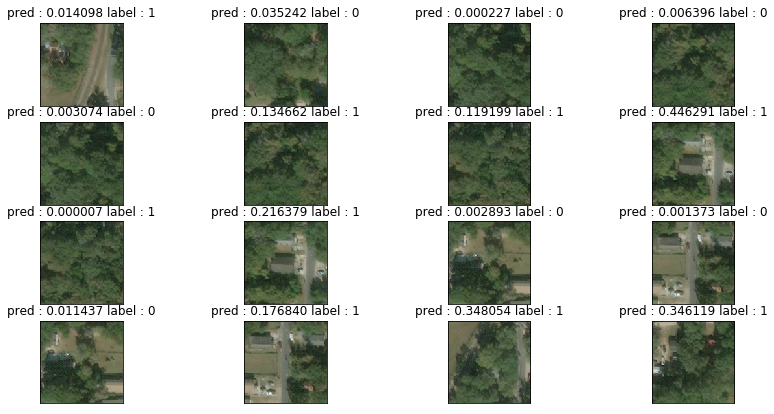

In [93]:
input_data = train_gen[0]
pred = model.predict(input_data[0])
pred = np.mean(pred, axis=1)
pred = np.mean(pred, axis=1)
label = input_data[1]
label = np.max(label, axis=1)
label = np.max(label, axis=1)
f, axarr = plt.subplots(4,4, figsize=(14, 7))
for i in range(4) :
    for j in range(4) :
        axarr[j,i].imshow(input_data[0][i+2*j])
        axarr[j,i].axes.get_xaxis().set_visible(False)      
        axarr[j,i].axes.get_yaxis().set_visible(False)
        axarr[j,i].set_title("pred : %f label : %d" % (pred[i+4*j], label[i+4*j]))

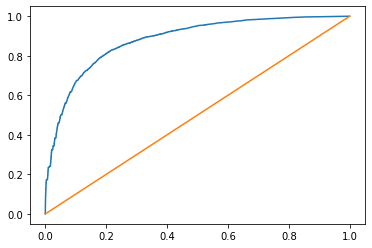

In [61]:
from sklearn.metrics import roc_curve

total_label = []
total_pred = []
for i in range(len(test_gen)):
    input_data = train_gen[0]
    pred = model.predict(input_data[0])
    label = input_data[1]
    total_pred.append(pred)
    total_label.append(label)
    
total_pred = np.array(total_pred)
total_label = np.array(total_label)

total_pred = total_pred.flatten()
total_label = total_label.flatten()

fpr, tpr, thresholds = roc_curve(total_label, total_pred)

plt.plot(fpr, tpr, label="ROC curve")
plt.plot(fpr, fpr)
